## Import main functions

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
import random
import seaborn as sns

In [ ]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [ ]:
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, Activation, Add, Conv2DTranspose
from keras.applications.vgg16 import VGG16

## Initialize Variables

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_folder="/content/drive/MyDrive/CamVid/resized/train"
valid_folder="/content/drive/MyDrive/CamVid/resized/val"
width = 512
height = 512
classes = 32
batch_size = 4
num_of_training_samples = len(os.listdir(train_folder)) 
num_of_testing_samples = len(os.listdir(valid_folder))

In [ ]:
train_files = os.listdir(train_folder)
# Print any image of your choice from the training set
s_no = 20

img = Image.open(os.path.join(train_folder, train_files[7])).convert("RGB")
img = np.array(img)


## Helper Functions

## Load Image and Segmentation Mask

In [ ]:
def LoadImage(name, path):
    img = Image.open(os.path.join(path, name))
    img = np.array(img)     
    image = img[:,:512]

    mask = img[:,512:]
    
    return image, mask

## Bin Segmentation Mask 

In [ ]:
def bin_image(mask):
    bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
    new_mask = np.digitize(mask, bins)
    return new_mask

## Segmentation Masks to Categorical Arrays 

In [ ]:
def getSegmentationArr(image, classes, width=width, height=height):
    seg_labels = np.zeros((height, width, classes))
    img = image[:, : , 0]

    for c in range(classes):
        seg_labels[:, :, c] = (img == c ).astype(int)
    return seg_labels

## Categorical Arrays to Colored Segmentation Masks

In [ ]:
def give_color_to_seg_img(seg, n_classes=32):
    
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

## Generator function to generate data batches

In [ ]:
def DataGenerator(path, batch_size=4, classes=32):
    files = os.listdir(path)
    while True:
        for i in range(0, len(files), batch_size):
            batch_files = files[i : i+batch_size]
            imgs=[]
            segs=[]
            for file in batch_files:
                #file = random.sample(files,1)[0]
                image, mask = LoadImage(file, path)
                mask_binned = bin_image(mask)
                labels = getSegmentationArr(mask_binned, classes)

                imgs.append(image)
                segs.append(labels)

            yield np.array(imgs), np.array(segs)

## Visualize Data Samples

In [ ]:
train_gen = DataGenerator(train_folder, batch_size=batch_size)
val_gen = DataGenerator(valid_folder, batch_size=batch_size)

In [ ]:
imgs, segs = next(train_gen)
imgs.shape, segs.shape

((4, 512, 512, 3), (4, 512, 512, 32))

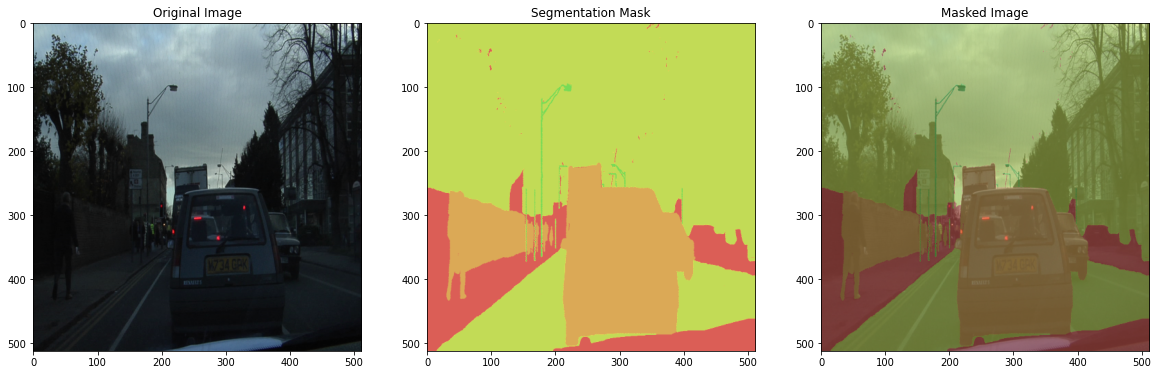

In [ ]:
image = imgs[0]
mask = give_color_to_seg_img(np.argmax(segs[0], axis=-1))
masked_image = cv2.addWeighted(image/255, 0.5, mask, 0.5, 0)

fig, axs = plot.subplots(1, 3, figsize=(20,20))
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(mask)
axs[1].set_title('Segmentation Mask')
#predimg = cv2.addWeighted(imgs[i]/255, 0.6, _p, 0.4, 0)
axs[2].imshow(masked_image)
axs[2].set_title('Masked Image')
plot.show()

## Segmentation model - FCN+Transfer Learning

In [ ]:
def fcn(vgg, classes = 32, fcn8 = False, fcn16 = False):
    pool5 = vgg.get_layer('block5_pool').output 
    pool4 = vgg.get_layer('block4_pool').output
    pool3 = vgg.get_layer('block3_pool').output

    conv_6 = Conv2D(1024, (7, 7), activation='relu', padding='same', name="conv_6")(pool5)
    conv_7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_7")(conv_6)
  
    conv_8 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_8")(pool4)
    conv_9 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_9")(pool3)
    
    deconv_7 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(conv_7)
    add_1 = Add()([deconv_7, conv_8])
    deconv_8 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(add_1)
    add_2 = Add()([deconv_8, conv_9])
    deconv_9 = Conv2DTranspose(classes, kernel_size=(8,8), strides=(8,8))(add_2)
    
    if fcn8 :
        output_layer = Activation('softmax')(deconv_9)
    elif fcn16 :
        deconv_10 = Conv2DTranspose(classes, kernel_size=(16,16), strides=(16,16))(add_1)
        output_layer = Activation('softmax')(deconv_10)
    else :
        deconv_11 = Conv2DTranspose(classes, kernel_size=(32,32), strides=(32,32))(conv_7)
        output_layer = Activation('softmax')(deconv_11)
    
    model = Model(inputs=vgg.input, outputs=output_layer)
    return model

In [ ]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(width, height, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
model = fcn(vgg, fcn16=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 512, 512, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

## Train our model

In [ ]:
adam = Adam(learning_rate=0.0001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
filepath = "/content/drive/MyDrive/CamVid/CamVid/"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(train_gen, epochs=11, steps_per_epoch=num_of_training_samples//batch_size,
                       validation_data=val_gen, validation_steps=num_of_testing_samples//batch_size,
                       callbacks=callbacks_list, use_multiprocessing=True)

Epoch 1/11
92/92 [==============================] - ETA: 0s - loss: 2.1495 - accuracy: 0.4632
Epoch 00001: val_accuracy improved from -inf to 0.79190, saving model to /content/drive/MyDrive/CamVid/CamVid/
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CamVid/CamVid/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


92/92 [==============================] - 181s 2s/step - loss: 2.1495 - accuracy: 0.4632 - val_loss: 0.7585 - val_accuracy: 0.7919
Epoch 2/11
92/92 [==============================] - ETA: 0s - loss: 0.7177 - accuracy: 0.7888
Epoch 00002: val_accuracy improved from 0.79190 to 0.79194, saving model to /content/drive/MyDrive/CamVid/CamVid/
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CamVid/CamVid/assets
92/92 [==============================] - 155s 2s/step - loss: 0.7177 - accuracy: 0.7888 - val_loss: 0.7089 - val_accuracy: 0.7919
Epoch 3/11
 1/92 [..............................] - ETA: 10s - loss: 0.6800 - accuracy: 0.7996

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


92/92 [==============================] - ETA: 0s - loss: 0.6677 - accuracy: 0.7925
Epoch 00003: val_accuracy did not improve from 0.79194
92/92 [==============================] - 147s 2s/step - loss: 0.6677 - accuracy: 0.7925 - val_loss: 0.6773 - val_accuracy: 0.7916
Epoch 4/11
92/92 [==============================] - ETA: 0s - loss: 0.6043 - accuracy: 0.8120
Epoch 00004: val_accuracy improved from 0.79194 to 0.79349, saving model to /content/drive/MyDrive/CamVid/CamVid/
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CamVid/CamVid/assets
92/92 [==============================] - 155s 2s/step - loss: 0.6043 - accuracy: 0.8120 - val_loss: 0.6706 - val_accuracy: 0.7935


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 5/11
92/92 [==============================] - ETA: 0s - loss: 0.5711 - accuracy: 0.8235
Epoch 00005: val_accuracy improved from 0.79349 to 0.81171, saving model to /content/drive/MyDrive/CamVid/CamVid/
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CamVid/CamVid/assets
92/92 [==============================] - 154s 2s/step - loss: 0.5711 - accuracy: 0.8235 - val_loss: 0.6089 - val_accuracy: 0.8117
Epoch 6/11


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


92/92 [==============================] - ETA: 0s - loss: 0.5615 - accuracy: 0.8329
Epoch 00006: val_accuracy improved from 0.81171 to 0.81546, saving model to /content/drive/MyDrive/CamVid/CamVid/
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CamVid/CamVid/assets
92/92 [==============================] - 154s 2s/step - loss: 0.5615 - accuracy: 0.8329 - val_loss: 0.5683 - val_accuracy: 0.8155
Epoch 7/11


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


92/92 [==============================] - ETA: 0s - loss: 0.5355 - accuracy: 0.8412
Epoch 00007: val_accuracy improved from 0.81546 to 0.82375, saving model to /content/drive/MyDrive/CamVid/CamVid/
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CamVid/CamVid/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


92/92 [==============================] - 157s 2s/step - loss: 0.5355 - accuracy: 0.8412 - val_loss: 0.5608 - val_accuracy: 0.8238


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 8/11
92/92 [==============================] - ETA: 0s - loss: 0.5114 - accuracy: 0.8516
Epoch 00008: val_accuracy improved from 0.82375 to 0.83291, saving model to /content/drive/MyDrive/CamVid/CamVid/
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CamVid/CamVid/assets
92/92 [==============================] - 155s 2s/step - loss: 0.5114 - accuracy: 0.8516 - val_loss: 0.5805 - val_accuracy: 0.8329
Epoch 9/11


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


92/92 [==============================] - ETA: 0s - loss: 0.4857 - accuracy: 0.8592
Epoch 00009: val_accuracy improved from 0.83291 to 0.84737, saving model to /content/drive/MyDrive/CamVid/CamVid/
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CamVid/CamVid/assets
92/92 [==============================] - 156s 2s/step - loss: 0.4857 - accuracy: 0.8592 - val_loss: 0.5364 - val_accuracy: 0.8474
Epoch 10/11


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


92/92 [==============================] - ETA: 0s - loss: 0.4650 - accuracy: 0.8654
Epoch 00010: val_accuracy improved from 0.84737 to 0.85621, saving model to /content/drive/MyDrive/CamVid/CamVid/
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CamVid/CamVid/assets
92/92 [==============================] - 160s 2s/step - loss: 0.4650 - accuracy: 0.8654 - val_loss: 0.5224 - val_accuracy: 0.8562
Epoch 11/11


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


92/92 [==============================] - ETA: 0s - loss: 0.4460 - accuracy: 0.8723
Epoch 00011: val_accuracy improved from 0.85621 to 0.87090, saving model to /content/drive/MyDrive/CamVid/CamVid/
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CamVid/CamVid/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


92/92 [==============================] - 159s 2s/step - loss: 0.4460 - accuracy: 0.8723 - val_loss: 0.4569 - val_accuracy: 0.8709


## Validation and Vizualization

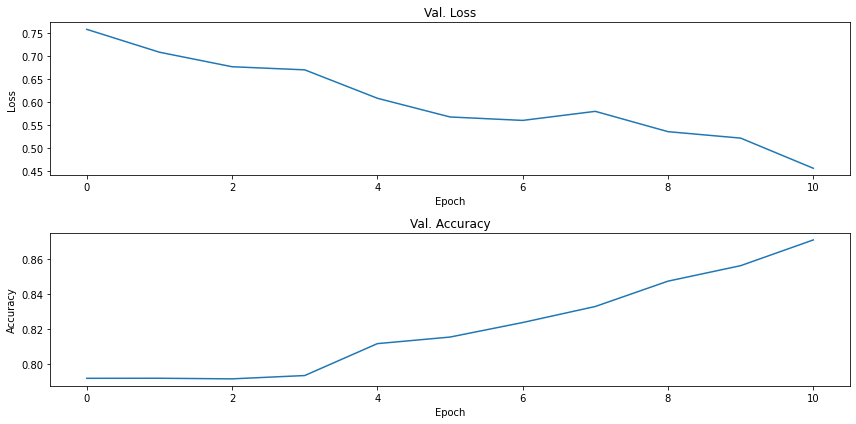

In [ ]:
loss = history.history["val_loss"]
acc = history.history["val_accuracy"] #accuracy

plot.figure(figsize=(12, 6))
plot.subplot(211)
plot.title("Val. Loss")
plot.plot(loss)
plot.xlabel("Epoch")
plot.ylabel("Loss")

plot.subplot(212)
plot.title("Val. Accuracy")
plot.plot(acc)
plot.xlabel("Epoch")
plot.ylabel("Accuracy")

plot.tight_layout()
plot.savefig("learn.png", dpi=150)
plot.show()

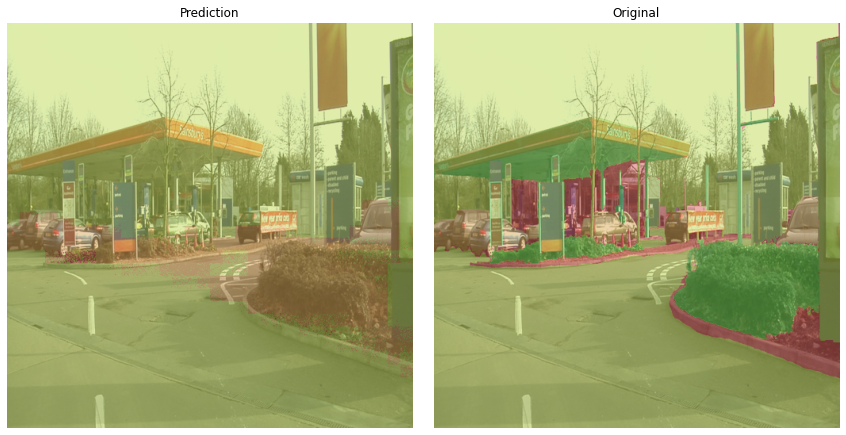

In [ ]:
#val_gen = DataGenerator(valid_folder)
max_show = 1
imgs, segs = next(val_gen)
pred = model.predict(imgs)

for i in range(max_show):
    _p = give_color_to_seg_img(np.argmax(pred[i], axis=-1))
    _s = give_color_to_seg_img(np.argmax(segs[i], axis=-1))

    predimg = cv2.addWeighted(imgs[i]/255, 0.5, _p, 0.5, 0)
    trueimg = cv2.addWeighted(imgs[i]/255, 0.5, _s, 0.5, 0)
    
    plot.figure(figsize=(12,6))
    plot.subplot(121)
    plot.title("Prediction")
    plot.imshow(predimg)
    plot.axis("off")
    plot.subplot(122)
    plot.title("Original")
    plot.imshow(trueimg)
    plot.axis("off")
    plot.tight_layout()
    plot.savefig("pred_"+str(i)+".png", dpi=150)
    plot.show()

In [ ]:
smooth = 1
import tensorflow as tf
def dice_coef(y_true, y_pred):
    And = tf.reduce_sum(y_true * y_pred)
    return (2 * And + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    sum_ = tf.reduce_sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    return 1 - iou(y_true, y_pred)

In [ ]:
dice_coef(trueimg,predimg)

<tf.Tensor: shape=(), dtype=float64, numpy=0.635140637292082>

In [ ]:
dice_coef_loss(trueimg,predimg)

<tf.Tensor: shape=(), dtype=float64, numpy=0.36485936270791797>

In [ ]:
iou(trueimg,predimg)

<tf.Tensor: shape=(), dtype=float64, numpy=0.4653528778180911>

In [ ]:
jac_distance(trueimg,predimg)

<tf.Tensor: shape=(), dtype=float64, numpy=0.5346471221819089>